In [1]:
#Recognize Handwriting using CNN + RNN with Keras and TensorFlow package
#Notebook presented by,
#Name:        Surya Narayanan S
#Reg No:      121015098
#Year & Dept: 4ITB

In [2]:
#List of all the packages, I have used

import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from IPython.display import display
from PIL import Image
import pylab as pl

In [3]:
#Change Working Directory, if required
#os.chdir('C:\\Users\\surya\\Documents\\Lab\\Python\\BigDataProject')

In [4]:
#Read CSV file using Pandas Dataframe
# https://www.kaggle.com/landlord/handwriting-recognition
train = pd.read_csv("HandwrittenDataset/written_name_train_v2.csv")
valid = pd.read_csv("HandwrittenDataset/written_name_validation_v2.csv")


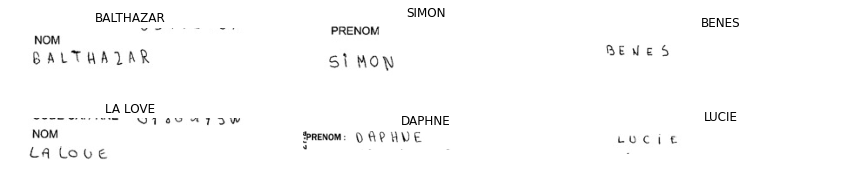

In [5]:
#Sample Images from Dataset

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'HandwrittenDataset/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)


In [6]:
#Remove NaNs
print("Number of NaNs in train set      : ", train['IDENTITY'].isnull().sum())
print("Number of NaNs in validation set : ", valid['IDENTITY'].isnull().sum())

train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)


Number of NaNs in train set      :  565
Number of NaNs in validation set :  78


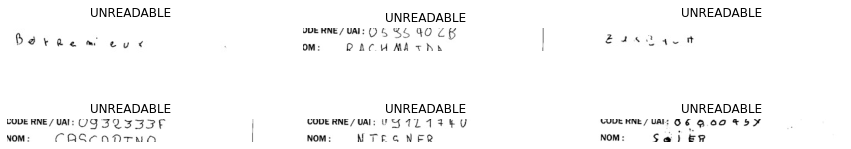

In [7]:
#Remove Unreadable Images

unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = 'HandwrittenDataset/train_v2/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)




train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']


In [8]:
#Convert all Labels to Uppercase Characters

train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()



train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)


In [9]:
#Preprocess Data

def preprocess(img):
    
    
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    #Invert + High Contrast Image
    ret, img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV) 
    #rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18)) 
    #dilation = cv2.dilate(thresh1, rect_kernel, iterations = 1) 
    #display(Image.fromarray(thresh1))
    (h, w) = img.shape
    final_img = np.ones([64, 256])*0 # blank white image
    
    # crop to 256,64 size
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    final_img = final_img.astype("uint8")
    #display(Image.fromarray(final_img))
    #Rotate Image to 90 Degree
    final_img = cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)
    #display(Image.fromarray(final_img))
    return final_img



Image Before Pre-Processing


Histogram of Image before Pre-processing


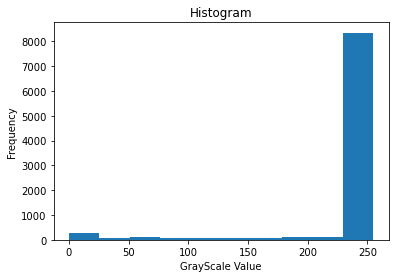

Image after Pre-Processing


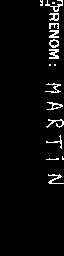

Histogram of Image after Pre-processing


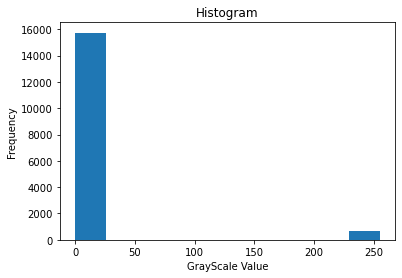

In [25]:
#Histogram of sample Image before preprocessing
fle = "HandwrittenDataset/test_v2/test/TEST_0006.jpg"
#fle = "HandwrittenDataset/Hello.jpg"
#fle = "HandwrittenDataset/Chandra1.jpg"
img = cv2.imread(fle, cv2.IMREAD_GRAYSCALE)
print("Image Before Pre-Processing")
display(Image.fromarray(img))
img2 = img.flatten()
plt.hist(img2)
plt.title("Histogram")
plt.xlabel("GrayScale Value")
plt.ylabel("Frequency")
print("Histogram of Image before Pre-processing")
plt.show()

processed = preprocess(img)
print("Image after Pre-Processing")
display(Image.fromarray(processed))
img2 = processed.flatten()
plt.hist(img2)
plt.title("Histogram")
plt.xlabel("GrayScale Value")
plt.ylabel("Frequency")
print("Histogram of Image after Pre-processing")
plt.show()

In [10]:
#Read Train Images from a folder and preprocess it using OpenCV
train_size = 30000


train_x = []

for i in range(train_size):
    img_dir = 'HandwrittenDataset/train_v2/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)
train_x = np.array(train_x).reshape(-1, 256, 64, 1)

In [11]:
#Read Test Images from a folder and preprocess it using OpenCV
valid_x = []
valid_size= 3000
start_ind = 0
for i in range(start_ind,start_ind+valid_size):
    img_dir = 'HandwrittenDataset/validation_v2/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)


In [12]:
# Map characters to a specific number from 0 to 26
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels

#Convert a given label to its corresponding Number
def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

#Convert given number list to its corresponding String
def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret



name = 'JEBASTIN'
print(name, '\n',label_to_num(name))

JEBASTIN 
 [ 9  4  1  0 18 19  8 13]


In [13]:
#Create Input matrix to give it to the Model
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    
    
    

print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], '\ntrain_input_len : ', train_input_len[100])


True label :  NOUR 
train_y :  [13. 14. 20. 17. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [15]:
#Create validation matrix to give it to the model for learning
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(start_ind,start_ind + valid_size):
    valid_label_len[i-start_ind] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i-start_ind, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

print('True label : ',valid.loc[100, 'IDENTITY'] , '\nvalid_y : ',valid_y[100],'\nvalid_label_len : ',valid_label_len[100], '\nvalid_input_len : ', valid_input_len[100])

    


True label :  CLOE 
valid_y :  [ 2. 11. 14.  4. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.] 
valid_label_len :  [4.] 
valid_input_len :  [62.]


In [16]:
#Construct the CRNN model

#https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53


input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
#https://colah.github.io/posts/2015-08-Understanding-LSTMs/
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()



Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)       256   

In [17]:
# the ctc loss function
#https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)




In [18]:
#Compile the built model with Adam Optimizer and CTC Loss function

labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)


# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))


In [ ]:
#Fit (Train) the model with Train dataset and validation dataset
model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output,  validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output), epochs=60, batch_size=128)


In [19]:
#To Load the saved Model
#model = tf.keras.models.load_model("tfmodelforhandwriting2")

In [20]:
#Predict handwritten Images
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [21]:
#To Find Accuracy of Predicted Characters and Predicted Word
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0
y_true_char = []
y_pred_char = []
for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
        y_true_char.append(tr[j])
        y_pred_char.append(pr[j])
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))


Correct characters predicted : 91.25%
Correct words predicted      : 75.17%


In [ ]:
#To save the Trained Model
#model.save("tfmodelforhandwriting3")

              precision    recall  f1-score   support

                   0.76      0.67      0.71        84
           '       0.00      0.00      0.00         2
           -       0.66      0.75      0.70        51
           A       0.94      0.94      0.94      2433
           B       0.94      0.85      0.90       446
           C       0.92      0.91      0.91       623
           D       0.92      0.88      0.90       588
           E       0.95      0.95      0.95      2399
           F       0.94      0.86      0.90       166
           G       0.90      0.94      0.92       362
           H       0.88      0.86      0.87       513
           I       0.94      0.95      0.94      1587
           J       0.86      0.90      0.88       140
           K       0.85      0.80      0.82       119
           L       0.95      0.95      0.95      1439
           M       0.90      0.86      0.88       740
           N       0.93      0.94      0.93      1506
           O       0.90    

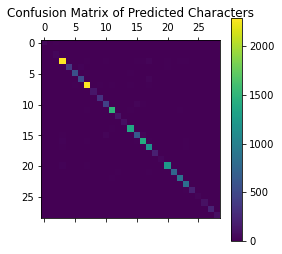

In [22]:
#Classification Report and Confusion Matrix
print(classification_report(y_true_char,y_pred_char))

cm = (confusion_matrix(y_true_char,y_pred_char))
pl.matshow(cm)
pl.title("Confusion Matrix of Predicted Characters")
pl.colorbar()
pl.show()

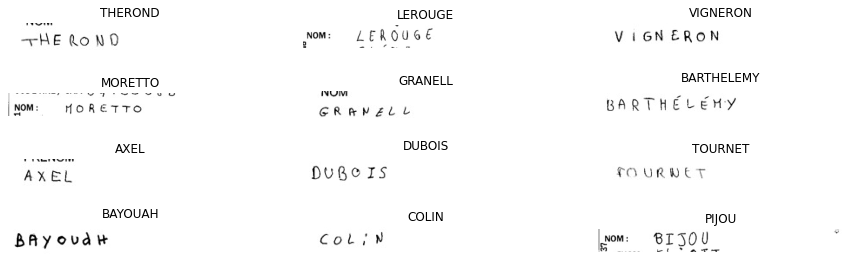

In [23]:
#To test sample Images. To view Sample Images along with predicted Label
#test = pd.read_csv("HandwrittenDataset/written_name_train_v2.csv")
test = pd.read_csv('HandwrittenDataset/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
start_img_ind = 3000
for i in range(start_img_ind,start_img_ind+12):
    ax = plt.subplot(4, 3, i+1-start_img_ind)
    img_dir = 'HandwrittenDataset/test_v2/test/'+test.loc[i, 'FILENAME']
    #img_dir = 'HandwrittenDataset/train_v2/train/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)
